# INFORMATION FROM HCZ:

### Here is a link to a map of our “Zone” https://hcz.org/zone-map/ 

- Ignore the sites plotted on the map and rather focus on the shaded blocks.
- The [census] blocks look promising, please use the Zone map to identify which blocks to focus in on.
- This does not include East Harlem.
 
### Our challenges at HCZ:

1) finding data on population and demographic changes in the Zone, since it’s not an area of land that maps perfectly into any tract, block group, school district, etc. 
   -- Though the ability to look at specific blocks does looks promising. 

2) Often times we have to make educated guesses based on the information available, 
 
### Specific question we are looking to answer: 

How many babies are born each year who reside in the Zone?

- We would like this information for the past 5 years.

- If possible, we’d want to know how many of the babies are to first time parents, though that is probably impossible to find out.
 

--------------------------------------------------------------------------
#### Minimum ask: Find better matching data 
#### Ideal ask: Build a model to approximate the number of children born each year in the Zone. Past 5 years.

- Focus on the shaded blocks in the Zone map to identify which blocks to focus in on.
--------------------------------------------------------------------------
##### Number of the babies that are to first time parents:

- Perhaps can use rough estimate: If you know or have some average for age of first time moms in zone area, you can extrapolate using data from this: https://censusreporter.org/profiles/79500US3603803-nycmanhattan-community-district-10central-harlem-puma-ny/

## Notes:

- The only (publicly) available data over number of births/birthrates that I could find for NYC neighborhoods was from the NYC Department of Health and Mental Hygeine, Bureau of Vital Statistics
- With the goal of finding better-matching data to determine the number of children born each year in the Zone (minimum: past 5 years), the closest data available to the geographic region of interest was data for Community District 10 and Census Tract Data.
- See Demographic Comparison PDF for a comparison of demographics and blocks within the Zone and Community District 10
- Key difference between data sets for Community District 10 and Census Tracts:
    - Community District: Single year aggregate counts (2000 - 2014; 15 data sets available)
    - Census Tract: Aggregated 5 year counts (2000 - 2004, 2002 - 2006, 2004 - 2008, 2006 - 2010, 2010 - 2014; 5 data sets available)
- Because there is already an existing birthrates model available (for approximating # of births) in Community District 10 (model can be found here: https://a816-healthpsi.nyc.gov/epiquery/Birth/index.html), the focus will be on developing a custom model for the Zone using data for census tracts that fall into the Zone. Because data is limited and based on 5 year aggregates, model will be 'rough'.
- The following census tracts (GEOIDs) will be used to narrow data set to the Zone:
    - 36061019000
    - 36061019800
    - 36061020000
    - 36061020800
    - 36061021000
    - 36061021200
    - 36061021400
    - 36061022000
    - 36061022200
    - 36061022400
    - 36061022600

In [1]:
# importing needed libraries

import csv
import time
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC


%matplotlib inline

#### Data sets from vital statistics NYC Dept of Health and Mental Hygeine
- Citation:
New York City Department of Health and Mental Hygiene, Bureau of Vital Statistics. Birth Micro SAS Datasets 2000-2014, distributed by Bureau of Vital Statistics, December 1, 2017. https://www1.nyc.gov/site/doh/data/data-sets/vital-statistics-birth-micro-sas-datasets.page


- Data Dictionary: https://www1.nyc.gov/assets/doh/downloads/pdf/vs/vs-micro-sas-birth%20datasets-descriptions.pdf

Name of data files:

- tractall_1014.sas7bdat
- tractall_0610.sas7bdat
- tractall_0408.sas7bdat
- tractall_0206.sas7bdat
- tractall_0004.sas7bdat



In [2]:
# Making sure the files can be read...

# from sas7bdat import SAS7BDAT
# with SAS7BDAT('tractall_1014.sas7bdat') as f:
#     for row in f:
#         print (row)

In [3]:
# Creating pandas dataframe for data, starting with data for 2010 - 2014

from sas7bdat import SAS7BDAT
with SAS7BDAT('tractall_1014.sas7bdat') as f:
    df10_14 = f.to_data_frame()

In [4]:
# adding column to identify period (timeframe) of data

df10_14['pd'] = 1014
df10_14.head()

,tract,birthtot,age1tot,age2tot,age3tot,age4tot,age5tot,age6tot,age7tot,age8tot,...,mth1tot,mth2tot,mth3tot,mth4tot,pob1tot,pob2tot,pob3tot,pob4tot,pob5tot,pd
0,1000201.0,202.0,None,NaN,6.0,47.0,66.0,46.0,29.0,NaN,...,145.0,NaN,28.0,24.0,NaN,140.0,62.0,NaN,NaN,1014
1,1000202.0,388.0,None,NaN,18.0,62.0,96.0,103.0,82.0,25.0,...,262.0,14.0,82.0,29.0,NaN,306.0,79.0,NaN,NaN,1014
2,1000600.0,852.0,None,5.0,22.0,145.0,307.0,234.0,114.0,22.0,...,617.0,13.0,138.0,79.0,NaN,690.0,160.0,NaN,NaN,1014
3,1000700.0,551.0,None,NaN,NaN,9.0,77.0,259.0,158.0,43.0,...,357.0,6.0,145.0,42.0,NaN,546.0,NaN,NaN,NaN,1014
4,1000800.0,1130.0,None,NaN,7.0,187.0,472.0,283.0,145.0,30.0,...,771.0,23.0,197.0,116.0,NaN,1031.0,99.0,NaN,NaN,1014


In [5]:
# Repeating the previous 2 steps for all data sets (total of 5 data sets = 5 dataframes)

from sas7bdat import SAS7BDAT
with SAS7BDAT('tractall_0610.sas7bdat') as f:
    df06_10 = f.to_data_frame()
    
df06_10['pd'] = 610
df06_10.head()

,tract,birthtot,age1tot,age2tot,age3tot,age4tot,age5tot,age6tot,age7tot,age8tot,...,mth1tot,mth2tot,mth3tot,mth4tot,pob1tot,pob2tot,pob3tot,pob4tot,pob5tot,pd
0,1000201.0,272.0,NaN,NaN,7.0,67.0,103.0,65.0,23.0,NaN,...,205.0,NaN,35.0,27.0,NaN,171.0,101.0,NaN,NaN,610
1,1000202.0,421.0,NaN,6.0,13.0,81.0,117.0,105.0,76.0,22.0,...,305.0,9.0,65.0,40.0,NaN,309.0,110.0,NaN,NaN,610
2,1000600.0,1223.0,NaN,8.0,24.0,269.0,511.0,274.0,108.0,29.0,...,935.0,11.0,169.0,96.0,NaN,917.0,304.0,NaN,NaN,610
3,1000700.0,355.0,NaN,NaN,NaN,8.0,43.0,182.0,100.0,19.0,...,224.0,NaN,106.0,20.0,NaN,349.0,NaN,NaN,NaN,610
4,1000800.0,1722.0,NaN,NaN,12.0,438.0,695.0,397.0,144.0,31.0,...,1292.0,17.0,275.0,117.0,NaN,1464.0,255.0,NaN,NaN,610


In [6]:
from sas7bdat import SAS7BDAT
with SAS7BDAT('tractall_0408.sas7bdat') as f:
    df04_08 = f.to_data_frame()
    
df04_08['pd'] = 408
df04_08.head()

,tract,birthtot,age1tot,age2tot,age3tot,age4tot,age5tot,age6tot,age7tot,age8tot,...,mth1tot,mth2tot,mth3tot,mth4tot,pob1tot,pob2tot,pob3tot,pob4tot,pob5tot,pd
0,1000201.0,276.0,NaN,6.0,8.0,73.0,109.0,62.0,16.0,NaN,...,220.0,NaN,31.0,21.0,NaN,169.0,106.0,NaN,NaN,408
1,1000202.0,436.0,NaN,12.0,17.0,92.0,113.0,103.0,75.0,23.0,...,321.0,11.0,63.0,40.0,NaN,299.0,134.0,NaN,NaN,408
2,1000600.0,1370.0,NaN,11.0,37.0,331.0,557.0,281.0,121.0,30.0,...,1071.0,12.0,176.0,108.0,NaN,995.0,373.0,NaN,NaN,408
3,1000700.0,204.0,NaN,NaN,NaN,6.0,27.0,99.0,58.0,12.0,...,128.0,NaN,63.0,9.0,NaN,199.0,NaN,NaN,NaN,408
4,1000800.0,1930.0,NaN,NaN,17.0,532.0,780.0,426.0,146.0,24.0,...,1535.0,10.0,268.0,113.0,NaN,1621.0,304.0,NaN,NaN,408


In [7]:
from sas7bdat import SAS7BDAT
with SAS7BDAT('tractall_0206.sas7bdat') as f:
    df02_06 = f.to_data_frame()
    
df02_06['pd'] = 206
df02_06.head()

,tract,birthtot,age1tot,age2tot,age3tot,age4tot,age5tot,age6tot,age7tot,age8tot,...,mth1tot,mth2tot,mth3tot,mth4tot,pob1tot,pob2tot,pob3tot,pob4tot,pob5tot,pd
0,1000201.0,268.0,NaN,7.0,10.0,72.0,106.0,54.0,16.0,NaN,...,219.0,NaN,29.0,17.0,NaN,169.0,97.0,NaN,NaN,206
1,1000202.0,441.0,NaN,8.0,22.0,94.0,118.0,100.0,77.0,22.0,...,328.0,15.0,66.0,32.0,NaN,289.0,151.0,NaN,NaN,206
2,1000600.0,1371.0,NaN,11.0,43.0,344.0,555.0,257.0,132.0,27.0,...,1104.0,17.0,164.0,82.0,NaN,954.0,410.0,NaN,NaN,206
3,1000700.0,90.0,NaN,NaN,NaN,NaN,19.0,37.0,25.0,5.0,...,58.0,NaN,27.0,NaN,NaN,87.0,NaN,NaN,NaN,206
4,1000800.0,1777.0,NaN,NaN,28.0,489.0,725.0,378.0,133.0,18.0,...,1480.0,12.0,207.0,76.0,NaN,1464.0,310.0,NaN,NaN,206


In [8]:
from sas7bdat import SAS7BDAT
with SAS7BDAT('tractall_0004.sas7bdat') as f:
    df00_04 = f.to_data_frame()
    
df00_04['pd'] = 4000
df00_04.head()

,tract,birthtot,age1tot,age2tot,age3tot,age4tot,age5tot,age6tot,age7tot,age8tot,...,mth1tot,mth2tot,mth3tot,mth4tot,pob1tot,pob2tot,pob3tot,pob4tot,pob5tot,pd
0,1000201.0,257.0,NaN,7.0,13.0,73.0,92.0,53.0,17.0,NaN,...,217.0,NaN,27.0,8.0,NaN,160.0,94.0,NaN,NaN,4000
1,1000202.0,421.0,NaN,10.0,22.0,91.0,126.0,94.0,64.0,14.0,...,316.0,11.0,66.0,28.0,NaN,280.0,140.0,NaN,NaN,4000
2,1000600.0,1327.0,NaN,10.0,42.0,335.0,512.0,248.0,154.0,23.0,...,1092.0,22.0,154.0,57.0,NaN,928.0,393.0,NaN,NaN,4000
3,1000800.0,1580.0,NaN,NaN,37.0,407.0,624.0,364.0,128.0,15.0,...,1361.0,12.0,153.0,51.0,NaN,1281.0,294.0,NaN,NaN,4000
4,1000900.0,82.0,NaN,NaN,NaN,5.0,16.0,34.0,23.0,NaN,...,62.0,NaN,13.0,5.0,NaN,78.0,NaN,NaN,NaN,4000


In [9]:
# Concatenating all 5 dataframes for one dataset 
# Although the timeframes overlap for 4 out of 5 data sets, final model will approximate births for 5-year periods

frames = [df10_14, df06_10, df04_08, df02_06, df00_04]

result = pd.concat(frames)

In [10]:
# Creating list of census tracts that fall within the Zone (cleanly) in order to filter data set

zone_census_tracts = [1019000, 1019800, 1020000, 1020800, 1021000, 1021200, \
                      1021400, 1022000, 1022200, 1022400, 1022600]

In [11]:
# Filtering dataset 

raw_data_vsBirths = result[result['tract'].isin(zone_census_tracts)]
raw_data_vsBirths

,age1tot,age2tot,age3tot,age4tot,age5tot,age6tot,age7tot,age8tot,age9tot,ancs10tot,...,prenat2tot,prenat3tot,prenat4tot,sex1tot,sex2tot,tract,weight1tot,weight2tot,weight3tot,weight4tot
184,NaN,NaN,10.0,42.0,39.0,68.0,72.0,27.0,6.0,NaN,...,NaN,NaN,NaN,136.0,130.0,1019000.0,NaN,NaN,NaN,NaN
193,NaN,NaN,NaN,22.0,16.0,38.0,22.0,13.0,NaN,NaN,...,NaN,NaN,NaN,61.0,55.0,1019800.0,NaN,NaN,NaN,NaN
195,NaN,NaN,8.0,24.0,32.0,46.0,32.0,10.0,NaN,NaN,...,NaN,NaN,NaN,78.0,75.0,1020000.0,NaN,NaN,NaN,NaN
201,NaN,NaN,16.0,52.0,66.0,70.0,53.0,18.0,NaN,NaN,...,NaN,NaN,NaN,133.0,147.0,1020800.0,NaN,NaN,NaN,NaN
203,NaN,11.0,27.0,77.0,110.0,97.0,65.0,10.0,NaN,NaN,...,NaN,NaN,NaN,220.0,178.0,1021000.0,NaN,NaN,NaN,NaN
205,NaN,NaN,8.0,30.0,56.0,79.0,56.0,12.0,NaN,NaN,...,NaN,NaN,NaN,107.0,137.0,1021200.0,NaN,NaN,NaN,NaN
207,NaN,NaN,8.0,28.0,38.0,37.0,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.0,67.0,1021400.0,NaN,NaN,NaN,NaN
212,NaN,NaN,16.0,88.0,89.0,137.0,89.0,37.0,NaN,11.0,...,NaN,NaN,NaN,230.0,232.0,1022000.0,NaN,NaN,NaN,NaN
214,NaN,NaN,18.0,36.0,38.0,45.0,68.0,12.0,NaN,NaN,...,NaN,NaN,NaN,106.0,117.0,1022200.0,NaN,NaN,NaN,NaN
217,NaN,15.0,32.0,123.0,115.0,101.0,56.0,17.0,NaN,NaN,...,NaN,NaN,NaN,225.0,234.0,1022400.0,NaN,NaN,NaN,NaN


In [12]:
# Conducting quick scan over full data set

with pd.option_context('display.max_rows', 2000, 'display.max_columns', 100):
   print(raw_data_vsBirths)

     age1tot  age2tot  age3tot  age4tot  age5tot  age6tot  age7tot  age8tot  \
184      NaN      NaN     10.0     42.0     39.0     68.0     72.0     27.0   
193      NaN      NaN      NaN     22.0     16.0     38.0     22.0     13.0   
195      NaN      NaN      8.0     24.0     32.0     46.0     32.0     10.0   
201      NaN      NaN     16.0     52.0     66.0     70.0     53.0     18.0   
203      NaN     11.0     27.0     77.0    110.0     97.0     65.0     10.0   
205      NaN      NaN      8.0     30.0     56.0     79.0     56.0     12.0   
207      NaN      NaN      8.0     28.0     38.0     37.0     29.0      NaN   
212      NaN      NaN     16.0     88.0     89.0    137.0     89.0     37.0   
214      NaN      NaN     18.0     36.0     38.0     45.0     68.0     12.0   
217      NaN     15.0     32.0    123.0    115.0    101.0     56.0     17.0   
219      NaN      NaN      9.0     50.0     58.0     76.0     51.0     18.0   
184      NaN      7.0     13.0     44.0     42.0    

In [13]:
# saving filtered data set as csv file (attached in email and on google shared drive [datakind/hcz])

raw_data_vsBirths.to_csv('/Users/cguy/Desktop/census_data/raw_data_vsBirths.csv')

In [14]:
from pandas_summary import DataFrameSummary

# Creating object to summarize dataframe

dfs = DataFrameSummary(raw_data_vsBirths)

In [15]:
with pd.option_context('display.max_rows', 2000, 'display.max_columns', 100):
   print(dfs.summary())


              age1tot  age2tot  age3tot  age4tot  age5tot  age6tot  age7tot  \
count               0       28       50       55       55       55       55   
mean              NaN  13.3214     18.5  54.4545  61.0364  61.6727  42.7636   
std               NaN  8.52471  11.5728   35.511  30.9964  29.3567  17.4047   
min               NaN        5        5        6       11       19       10   
25%               NaN        6     9.25       29       38       38     31.5   
50%               NaN     10.5     15.5       42       51       60       38   
75%               NaN     18.5    24.75       77     85.5       78       54   
max               NaN       34       52      143      119      137       89   
counts              0       28       50       55       55       55       55   
uniques             0       20       28       45       40       42       37   
missing            55       27        5        0        0        0        0   
missing_perc     100%   49.09%    9.09%       0%    

In [16]:
dfs.columns_types

numeric     90
constant     6
bool         4
Name: types, dtype: int64

/Users/cguy/anaconda3/lib/python3.6/site-packages/pandas_summary/__init__.py:130: RuntimeWarning: invalid value encountered in minimum
  capped_series = np.minimum(series, series.mean() + multiplier * series.std())
/Users/cguy/anaconda3/lib/python3.6/site-packages/pandas_summary/__init__.py:143: RuntimeWarning: invalid value encountered in minimum
  capped_series = np.minimum(series, series.median() + multiplier * series.mad())


mean                                                                 15.1667
std                                                                  6.92001
variance                                                             47.8865
min                                                                        5
max                                                                       37
5%                                                                      5.35
25%                                                                       10
50%                                                                       14
75%                                                                    18.25
95%                                                                    25.95
iqr                                                                     8.25
kurtosis                                                             1.81607
skewness                                                             1.03382

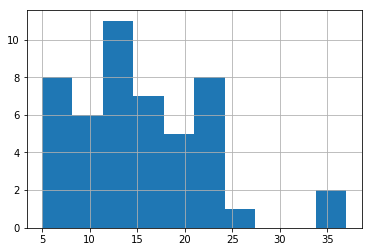

In [17]:
# looking at one column (age8tot) randomly, in detail
# RECOMMENDED FUTURE STEP: For future analysis, should complete thorough EDA, 
# including utilization of this object property for each column in data set

dfs['age8tot']

In [18]:
raw_data_vsBirths.columns

Index(['age1tot', 'age2tot', 'age3tot', 'age4tot', 'age5tot', 'age6tot',
       'age7tot', 'age8tot', 'age9tot', 'ancs10tot', 'ancs11tot', 'ancs12tot',
       'ancs13tot', 'ancs14tot', 'ancs15tot', 'ancs1tot', 'ancs2tot',
       'ancs3tot', 'ancs4tot', 'ancs5tot', 'ancs6tot', 'ancs7tot', 'ancs8tot',
       'ancs9tot', 'ancs_oth_tot', 'apg1tot', 'apg2tot', 'apg3tot', 'apg4tot',
       'apg5tot', 'birthtot', 'bpl10tot', 'bpl11tot', 'bpl12tot', 'bpl13tot',
       'bpl14tot', 'bpl15tot', 'bpl1tot', 'bpl2tot', 'bpl3tot', 'bpl4tot',
       'bpl5tot', 'bpl6tot', 'bpl7tot', 'bpl8tot', 'bpl9tot', 'bpl_oth_tot',
       'bwt1tot', 'bwt2tot', 'bwt3tot', 'bwt4tot', 'bwt5tot', 'bwt6tot',
       'bwt7tot', 'bwt8tot', 'bwt9tot', 'educ1tot', 'educ2tot', 'educ3tot',
       'eth_ap_tot', 'eth_bl_tot', 'eth_hi_tot', 'eth_wh_tot', 'ga1tot',
       'ga2tot', 'ga3tot', 'ga4tot', 'ga5tot', 'mar1tot', 'mar2tot', 'mth1tot',
       'mth2tot', 'mth3tot', 'mth4tot', 'nat1tot', 'nat2tot', 'par1tot',
       'par2tot

## NOTES ABOUT DATA SET & MODEL DEVELOPMENT PLAN

- As seen above, the data set contains a ___significant___ amount of NaNs in several columns.
- Considering the fact that the value 0.0 (zero) exists in the data set, I am making the assumption that NaNs represent missing data.
- Dropping rows with NaNs will decrease an already sparse data set.
- High Dimensionality (lots of columns/features)
- Categorical data has already been encoded (except for the 'pd' column that I added earlier to indicate time frame).

- Considering notes above, I will complete the following plan:

    (A) Drop 'tract' column -- no significance
    
    (B) Drop any columns with 100% missing data -- to help reduce # of features
    
    (C) Encode 'pd' column -- using one hot encoder/get dummies/indicator variables
    
    (D) Address Missing Data:
    
     - Create 2 data sets: 
        
     (1) ZoneData_imputed0: Missing values imputed with 0 (zero)
     
     (2) ZoneData_imputedMean: Missing values imputed with mean
           
      __NOTE__: Future analysis should refer to skewness, etc. of column and impute values with median/mean/mode depending on descriptive stats. Check this link out for a good reference, if needed: https://machinelearningmastery.com/handle-missing-data-python/
                
  (E) Build and evaluate the following model on the 2 data sets:
    
     - Lasso Least Angle Regression (Documentation: http://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression)
     
     - Pros of the LARS method include (from documentation):
       - It is numerically efficient when the number of dimensions is significantly greater than the number of points
       - It is computationally just as fast as forward selection and has the same order of complexity as an ordinary least squares.
       - It produces a full piecewise linear solution path, which is useful in cross-validation or similar attempts to tune the model.
       - If two variables are almost equally correlated with the response, then their coefficients should increase at approximately the same rate. The algorithm thus behaves as intuition would expect, and also is more stable.
     
     - Cons of the LARS method include (from documentation):
       - Because LARS is based upon an iterative refitting of the residuals, it would appear to be especially sensitive to the effects of noise.
       
     __NOTE__: Future model development/evaluation should include standardization steps. See recommended documentation here: http://blog.minitab.com/blog/adventures-in-statistics-2/what-are-the-effects-of-multicollinearity-and-when-can-i-ignore-them

  (F) Pick best performing model and then Pickle Model for future use

------------------------------------------------------------------------------------------------------------------

In [19]:
# (A) Drop 'tract' column -- no significance

raw_data_vsBirths = raw_data_vsBirths.drop('tract', axis=1)

In [20]:
# (B) Drop any columns with 100% missing data -- to help reduce # of features

raw_data_vsBirths = raw_data_vsBirths.drop(['age1tot', 'ancs12tot', 'ancs13tot', 'bpl11tot', \
                                            'bpl12tot', 'bpl14tot', 'pob4tot', 'pob5tot'], axis=1)

In [21]:
# (C) Encode 'pd' column

encoded_pd_col = pd.get_dummies(raw_data_vsBirths['pd'])
raw_data_vsBirths = pd.concat([encoded_pd_col, raw_data_vsBirths], axis=1)

#dropping original 'pd' column
raw_data_vsBirths = raw_data_vsBirths.drop('pd', axis=1)
raw_data_vsBirths.columns

Index([           206,            408,            610,           1014,
                 4000,      'age2tot',      'age3tot',      'age4tot',
            'age5tot',      'age6tot',      'age7tot',      'age8tot',
            'age9tot',    'ancs10tot',    'ancs11tot',    'ancs14tot',
          'ancs15tot',     'ancs1tot',     'ancs2tot',     'ancs3tot',
           'ancs4tot',     'ancs5tot',     'ancs6tot',     'ancs7tot',
           'ancs8tot',     'ancs9tot', 'ancs_oth_tot',      'apg1tot',
            'apg2tot',      'apg3tot',      'apg4tot',      'apg5tot',
           'birthtot',     'bpl10tot',     'bpl13tot',     'bpl15tot',
            'bpl1tot',      'bpl2tot',      'bpl3tot',      'bpl4tot',
            'bpl5tot',      'bpl6tot',      'bpl7tot',      'bpl8tot',
            'bpl9tot',  'bpl_oth_tot',      'bwt1tot',      'bwt2tot',
            'bwt3tot',      'bwt4tot',      'bwt5tot',      'bwt6tot',
            'bwt7tot',      'bwt8tot',      'bwt9tot',     'educ1tot',
      

In [22]:
# (D) Address Missing Data:

# Create 2 data sets:
    
# (1) ZoneData_imputed0: Missing values imputed with 0 (zero)
    
ZoneData_imputed0 = raw_data_vsBirths.fillna(value=0)
    
# (2) ZoneData_imputedMean: Missing values imputed with mean
    
ZoneData_imputedMean = raw_data_vsBirths.fillna(raw_data_vsBirths.mean())


Computing regularization path using the Lars lasso...


(0, 1000)

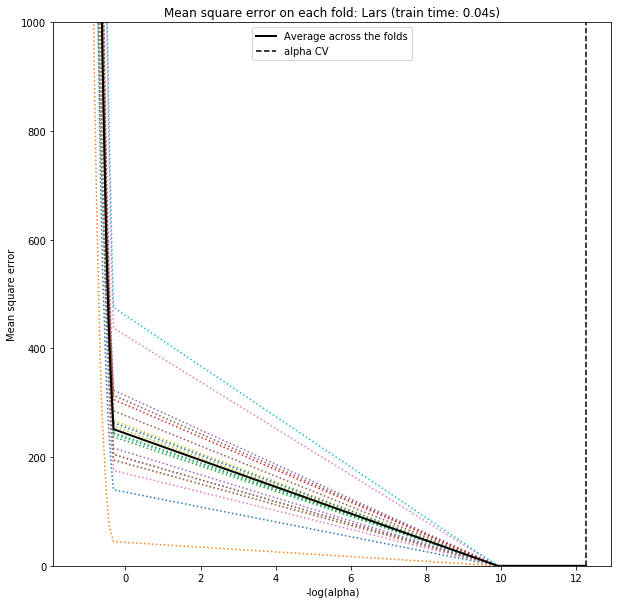

In [23]:
# (E) Build and evaluate the following model on the 2 data sets: Lasso Least Angle Regression

# # (1) ZoneData_imputed0, using LassoLarsCV (cross-validation)

# Setting X and Y (features and target data)

X_imputeZero = ZoneData_imputed0.drop('birthtot', axis = 1)
Y_imputeZero = ZoneData_imputed0['birthtot']

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()

# Fit model on training data using LassoLarsCV

model_imputeZero = LassoLarsCV(cv=20).fit(X_imputeZero, Y_imputeZero)

t_lasso_lars_cv = time.time() - t1

# Display results of alphas
m_log_alphas = -np.log10(model_imputeZero.cv_alphas_)

plt.figure(figsize=(10,10))
ymin, ymax = 0, 1000
plt.plot(m_log_alphas, model_imputeZero.mse_path_, ':')
plt.plot(m_log_alphas, model_imputeZero.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model_imputeZero.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)



In [24]:
model_imputeZero.get_params

<bound method BaseEstimator.get_params of LassoLarsCV(copy_X=True, cv=20, eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)>

In [25]:
# Scoring model on 'test' data
# Using subset of data (2010 - 2014) to test/score model
# However, need to use real test data when new data is available

y_test = ZoneData_imputed0[ZoneData_imputed0[1014]==1]
y_test = y_test['birthtot']
X_test = X_imputeZero[X_imputeZero[1014]==1]

model_imputeZero.score(X_test, y_test)

1.0

---------------------

Computing regularization path using the Lars lasso...


(0, 1000)

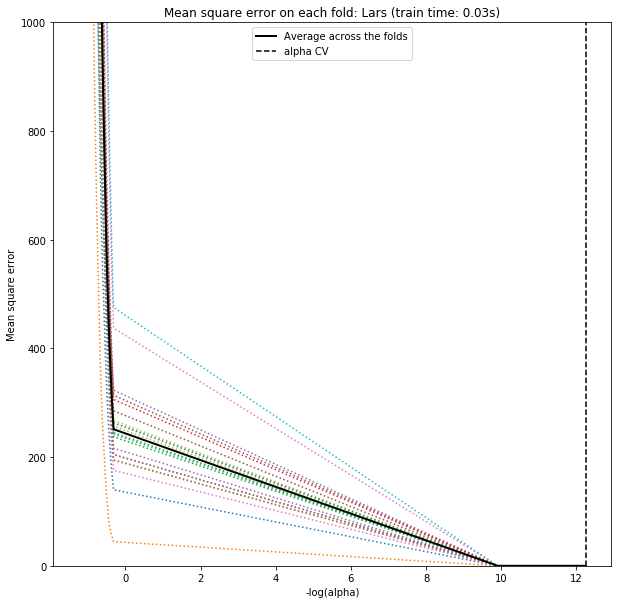

In [26]:
# (E) Build and evaluate the following model on the 2 data sets: Lasso Least Angle Regression

# # (1) ZoneData_imputedMean, using LassoLarsCV (cross-validation)

# Setting X and Y (features and target data)

X_imputeMean = ZoneData_imputedMean.drop('birthtot', axis = 1)
Y_imputeMean = ZoneData_imputedMean['birthtot']

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()

# Fit model on training data using LassoLarsCV

model_imputeMean = LassoLarsCV(cv=20).fit(X_imputeMean, Y_imputeMean)

t_lasso_lars_cv = time.time() - t1

# Display results of alphas
m_log_alphas = -np.log10(model_imputeMean.cv_alphas_)

plt.figure(figsize=(10,10))
ymin, ymax = 0, 1000
plt.plot(m_log_alphas, model_imputeMean.mse_path_, ':')
plt.plot(m_log_alphas, model_imputeMean.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model_imputeMean.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)



In [27]:
model_imputeMean.get_params

<bound method BaseEstimator.get_params of LassoLarsCV(copy_X=True, cv=20, eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)>

In [28]:
# Scoring model on 'test' data
# Using subset of data (2010 - 2014) to test/score model
# However, need to use real test data when new data is available

y_test = ZoneData_imputedMean[ZoneData_imputedMean[1014]==1]
y_test = y_test['birthtot']
X_test = X_imputeMean[X_imputeMean[1014]==1]

model_imputeMean.score(X_test, y_test)

1.0

## NOTES ON MODELS

#### R^2 scores are 1.0 for both models because not using actual test (unseen) data to score. 
#### Need to re-do when new data available to use as test data.

In [29]:
# (F) Pickle Model (great resource for pickle steps: 
#                   https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)

# Pickling models to share

from sklearn.externals import joblib

try:
   import cPickle as pickle
except:
   import pickle

# save the model to disk
# They are also attached in email and on shared drive [datakind/hcz]
filename_1 = '/Users/cguy/Desktop/census_data/HCZ_births_finalized_model_imputeZero.sav'
filename_2 = '/Users/cguy/Desktop/census_data/HCZ_births_finalized_model_imputeMean.sav'

joblib.dump(model_imputeZero, filename_1)
joblib.dump(model_imputeMean, filename_2)
 


['/Users/cguy/Desktop/census_data/HCZ_births_finalized_model_imputeMean.sav']

In [30]:
# To access pickled model...
 
# load the model from disk
loaded_model = joblib.load(filename_1)
result = loaded_model.score(X_test, y_test)
print(result)

1.0


In [32]:
loaded_model.predict(X_test)

array([ 266.,  116.,  153.,  280.,  398.,  244.,  142.,  462.,  223.,
        459.,  263.])